<a href="https://colab.research.google.com/github/MarijanMarkovic/Numerical-modelling-of-differential-equations/blob/main/Stabilization_vj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install -y --no-install-recommends fenics
!rm -rf *

Calling FFC just-in-time (JIT) compiler, this may take some time.
n = 10, error L2 = 4.416e-04, error H1 = 0.0024350850128253315
n = 20, error L2 = 4.412e-04, error H1 = 0.0024414903342675673
n = 40, error L2 = 4.411e-04, error H1 = 0.002443181694268808
n = 80, error L2 = 4.411e-04, error H1 = 0.002443611483450725


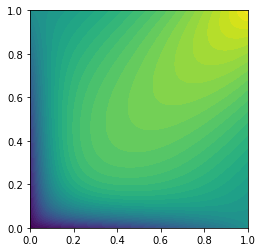

In [ ]:
from fenics import*
import matplotlib.pyplot as plt


degree=1

mu=Constant(1.e-1)
bx, by=1, 1
b=Constant((bx, by))
Sigma=Constant(0.0)

f=Constant(0.0)
u_exact=Expression('((exp(bx * x[0])/mu)-1)/(exp(bx/mu)-1)+'
                   '((exp(by * x[1])/mu)-1)/(exp(by/mu)-1)',
                  mu=mu, bx=bx, by=by, degree=degree * 2 + 1)

delta=Constant(1.0)

def solve_problem(nx, ny, degree, f, u_exact, delta):
  #1. Mesh Gen
  mesh=UnitSquareMesh(nx, ny,'crossed')
  
  #2. Finite Element Space
  V=FunctionSpace(mesh, 'CG', degree)

  g_boundary=u_exact

  def boundary(x, on_boundary):
    return on_boundary

  bc=DirichletBC(V, g_boundary, boundary)

  #3. Assembling/Solving
  u=TrialFunction(V)
  v=TestFunction(V)
  
  a=(mu * dot(grad(u), grad(v)) + dot(b, grad(u)) * v) * dx
  L=f * v * dx
  
  h = CellDiameter(mesh)
  bnorm = sqrt(dot(b, b))
  tau_K = 0.5 * delta * h / conditional(bnorm * h > 6 * mu, bnorm, 6 * mu / h)

  rho = Constant(0)
  A = lambda u: -mu * div(grad(u)) + dot(b, grad(u))
  A_S = lambda u: -mu * div(grad(u)) - 0.5 * div(b) * u
  A_SS = lambda u: dot(b, grad(u)) + 0.5 * div(b) * u

  a_stabilization = tau_K * A(u) * (A_SS(v) + rho * A_S(v)) * dx
  
  #a = a + a_stabilization

  u = Function(V)
  u.rename('solution', 'solution')
  solve(a == L, u, bc)
  
  return mesh, u


for n in [10, 20, 40, 80]:
  mesh, u = solve_problem(n, n, degree, f, u_exact, delta)
  print('n = {}, error L2 = {:.3e}, error H1 = {}'.format(n,
    errornorm(u_exact, u, 'L2'),
    errornorm(u_exact, u, 'H10')))
  
plot(u)
plt.show()

VTKfile=File('Stabilization.pvd')
VTKfile << u

Coefficient(FunctionSpace(None, FiniteElement('Lagrange', None, 3)), 7)